In [5]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpy as np
import scipy
import bilby
from jax.config import config; config.update("jax_enable_x64", True)


from sklearn import mixture

from corner import corner, hist2d

import jaxopt

from tqdm import tqdm

import matplotlib.pyplot as plt

import pystroke

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
unif = bilby.core.prior.Uniform(-10,10)

prior_cdfs = [unif.cdf, unif.cdf]

In [3]:
dims = 2
Nobs = 30

# Construct random posteriors
event_list = []
pdet = dist.Normal(loc=jnp.zeros(dims), scale=jnp.ones(dims))
#dist.Uniform(-5*jnp.ones(dims),5*jnp.ones(dims))

means = []
covs = []

for i in range(Nobs):
    
    theta = np.random.uniform(0, 2*np.pi)
    
    cov = np.dot(
        np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]]).T,
        np.dot(
        np.diag(np.random.uniform(0.01,0.5,size=dims)),
        np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    ))
    
    loc = np.random.randn(dims) + np.random.multivariate_normal(np.zeros(dims), cov)
    
    means.append(loc)
    covs.append(cov)
    
    key = jax.random.PRNGKey(np.random.randint(0,1000000))
    dist_i_samples = dist.MultivariateNormal(jnp.array(loc), jnp.array(cov)).sample(key, sample_shape=(2000,))
    
    event_list.append(pystroke.GMMDistribution(dist_i_samples, prior_cdfs))

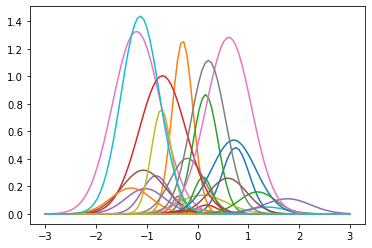

In [4]:
xs = np.linspace(-3,3,100)
ys = np.linspace(-3,3,100)
zs = np.zeros(100)

for i in range(Nobs):
    
    plt.plot(xs, np.exp(event_list[i].log_prob(jnp.array([xs,xs]).T)))
    
plt.show()

In [5]:
pistroke_test = pystroke.PiStroke(event_list, pdet)

In [8]:
_ = pistroke_test.gradient_descent(iterations=2, tol=np.array([1e-4,1e-2]))


 Final logL -36.18298209584607


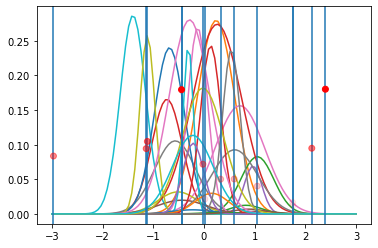

In [9]:
xs = np.linspace(-3,3,100)
ys = np.linspace(-3,3,100)
zs = np.zeros(100)

for i in range(Nobs):
    
    plt.plot(xs, np.exp(event_list[i].log_prob(jnp.array([xs]).T))/5)
    
plt.scatter(pistroke_test.result_array_gd[:,0], 
            np.exp(pistroke_test.result_array_gd[:,-1])/np.sum(np.exp(pistroke_test.result_array_gd[:,-1])),
            zorder=100, color='r', 
            alpha=np.exp(pistroke_test.result_array_gd[:,-1])/np.max(np.exp(pistroke_test.result_array_gd[:,-1])))

for i in range(len(pistroke_test.result_array_gd)):
    plt.axvline(pistroke_test.result_array_gd[i,0])

plt.show()

(-4.0, 4.0)

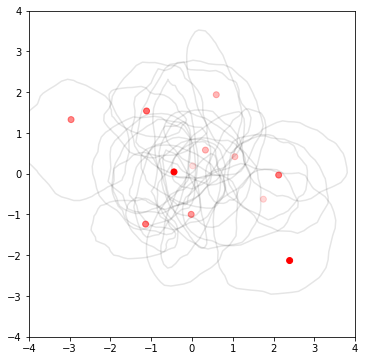

In [10]:
fig = plt.figure(figsize=[6,6])

for i in range(len(event_list)):
    samples = event_list[i].samples
    hist2d(samples[:,0], samples[:,1], new_fig=False, levels=[0.9], 
           smooth=0.9, bins=25, plot_density=False, plot_datapoints=False, color='k', contour_kwargs={'alpha':0.1})

plt.scatter(pistroke_test.result_array_gd[:,0], pistroke_test.result_array_gd[:,1],zorder=100, color='r',
            alpha=np.exp(pistroke_test.result_array_gd[:,-1])/np.max(np.exp(pistroke_test.result_array_gd[:,-1])))

ax = plt.gca()
ax.set_aspect('equal')
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

In [10]:
np.exp(pistroke_test.result_array_gd[:,-1])

array([0.01861721, 0.02418935, 0.02955456, 0.03799293, 0.01262984,
       0.02750471, 0.03640356, 0.04260695, 0.02123043, 0.02191476,
       0.06477562, 0.01989207, 0.07713503, 0.02095531, 0.00794407,
       0.0463539 , 0.00335526, 1.54977309, 0.06522635, 0.04855763,
       0.0478653 , 0.02539441, 0.0477604 , 0.05179561, 0.03452126,
       0.03690946, 0.034297  , 0.01629051, 0.08295022, 0.01708356])